In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata

from sklearn.neighbors import BallTree, KDTree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
from joblib import delayed, Parallel
import os
from scipy.stats import ranksums, zscore
from itertools import combinations
from nheatmap import nhm

In [2]:
def cells_within_radius(adata,cell_type_col,target_cell, radius=10):
    """
    Find all cells within a given radius (in microns) of Granule cells in a spatial seq anndata object.

    Parameters:
    adata : AnnData
        Annotated data matrix.
    radius : float
        Radius in microns to search for neighboring cells. Default is 10 microns.

    Returns:
    pd.DataFrame
        DataFrame with indices of cells within the given radius of Granule cells.
    """
    new_adata = adata.copy()
    new_adata.obs.set_index('Name', inplace=True)
    # Extract coordinates and batch IDs
    x_coords = new_adata.obs['x'].values
    y_coords = new_adata.obs['y'].values
    batch_ids = new_adata.obs['batchID'].values
    cell_types = new_adata.obs[cell_type_col]
    
    new_adata.obs[f"peri_{target_cell}"] = False

    granule_indices = np.where(cell_types == target_cell)[0]

    results = []

    # Iterate through each Granule cell and find neighboring cells
    for granule_idx in tqdm(granule_indices, desc="Processing Peri Granule Cells"):
        granule_x = x_coords[granule_idx]
        granule_y = y_coords[granule_idx]
        granule_batch = batch_ids[granule_idx]

        # Calculate distances to all other cells in the same batch
        same_batch_indices = np.where(batch_ids == granule_batch)[0]
        same_batch_x = x_coords[same_batch_indices]
        same_batch_y = y_coords[same_batch_indices]

        distances = np.sqrt((same_batch_x - granule_x)**2 + (same_batch_y - granule_y)**2)

        within_radius_indices = same_batch_indices[np.where(distances <= radius)[0]]

        new_adata.obs.iloc[within_radius_indices, new_adata.obs.columns.get_loc(f"peri_{target_cell}")] = True

    return new_adata


def shift_log_normalized(adata):
    """
    Shift log-normalized values to be non-negative.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    
    Returns:
    AnnData
        AnnData object with shifted log-normalized values.
    """
    adata_copy = adata.copy()
    min_val = adata_copy.X.min()
    if min_val < 0:
        adata_copy.X = adata_copy.X - min_val
    return adata_copy

def differential_expression(adata1, adata2, shift_log_values=True):
    """
    Perform differential expression analysis between two AnnData objects.

    Parameters:
    adata1 : AnnData
        First annotated data matrix.
    adata2 : AnnData
        Second annotated data matrix.
    shift_log_values : bool
        Whether to shift log-normalized values to be non-negative.

    Returns:
    pd.DataFrame
        DataFrame containing differential expression results.
    """
    # Add a column indicating the origin of each cell
    adata1.obs['group'] = 'group1'
    adata2.obs['group'] = 'group2'

    if shift_log_values:
        adata1 = shift_log_normalized(adata1)
        adata2 = shift_log_normalized(adata2)

    # Concatenate the two AnnData objects
    adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])

    # Perform differential expression analysis using Scanpy
    sc.tl.rank_genes_groups(adata_combined, groupby='batch', reference='group1', method='wilcoxon')

    # Extract results into a DataFrame
    results = adata_combined.uns['rank_genes_groups']
    groups = results['names'].dtype.names
    pvals = pd.DataFrame({group + '_pvals': results['pvals'][group] for group in groups})
    pvals_adj = pd.DataFrame({group + '_pvals_adj': results['pvals_adj'][group] for group in groups})
    logfoldchanges = pd.DataFrame({group + '_logfoldchanges': results['logfoldchanges'][group] for group in groups})
    names = pd.DataFrame({group + '_names': results['names'][group] for group in groups})

    return pd.concat([names, pvals, pvals_adj, logfoldchanges], axis=1)

def plot_volcano(
    df, 
    sig_lfc=0.5, 
    group='group2', 
    pval_col_suffix='_pvals', 
    logfc_col_suffix='_logfoldchanges', 
    name_col_suffix='_names', 
    title='Volcano Plot', 
    xlims=None, 
    savefig=None
):
    """
    Plot a volcano plot for differential expression analysis results.

    Parameters:
    df : pd.DataFrame
        DataFrame containing differential expression results.
    group : str
        Group name for differential expression results.
    pval_col_suffix : str
        Suffix for the p-value column in the DataFrame.
    logfc_col_suffix : str
        Suffix for the log fold change column in the DataFrame.
    name_col_suffix : str
        Suffix for the gene names column in the DataFrame.
    title : str
        Title for the plot.
    xlims : tuple, optional
        Limits for the x-axis.
    savefig : str, optional
        Path to save the figure.

    Returns:
    list, list
        Two lists containing significant genes with log fold change < 1 and > 1.
    """
    pvals = df[group + pval_col_suffix]
    logfoldchanges = df[group + logfc_col_suffix]
    gene_names = df[group + name_col_suffix]
    
    # Define significance thresholds
    sig_pval = 0.05
    sig_logfc = sig_lfc
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(logfoldchanges, -np.log10(pvals), color='grey', alpha=0.5, label='NS')
    
    # Highlight significant points
    sig_points = (pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)
    plt.scatter(logfoldchanges[sig_points], -np.log10(pvals[sig_points]), color='red', alpha=0.50, label='P-value and log2 FC')
    plt.scatter(logfoldchanges[(pvals < sig_pval) & ~sig_points], -np.log10(pvals[(pvals < sig_pval) & ~sig_points]), color='blue', alpha=0.50, label='P-value')
    plt.scatter(logfoldchanges[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)], -np.log10(pvals[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)]), color='green', alpha=0.50, label='Log2 FC')
    
    plt.axhline(y=-np.log10(sig_pval), color='black', linestyle='--')
    plt.axvline(x=sig_logfc, color='black', linestyle='--')
    plt.axvline(x=-sig_logfc, color='black', linestyle='--')
    
    # Annotate significant genes
    texts = []
    sig_genes_less_than_1 = []  # List for significant genes with logFC < 1
    sig_genes_greater_than_1 = []  # List for significant genes with logFC > 1

    for i in range(len(gene_names)):
        if sig_points[i]:
            if logfoldchanges[i] < -1*sig_lfc:
                sig_genes_less_than_1.append(gene_names[i])
            elif logfoldchanges[i] > sig_lfc:
                sig_genes_greater_than_1.append(gene_names[i])

            texts.append(plt.text(logfoldchanges[i], -np.log10(pvals[i]), gene_names[i], fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    plt.xlabel('Log2 fold change')
    plt.ylabel('-Log10 P-value')
    plt.title(title)
    plt.legend(loc='best')
    
    if xlims is not None:
        plt.xlim(xlims)
        
    if savefig is not None:
        plt.savefig(savefig, format='pdf')
        
    plt.show()
    
    return sig_genes_less_than_1, sig_genes_greater_than_1

def add_activated_microglia_column(adata, cell_type_col='updated_celltype', cd9_threshold=9):
    """
    Add a column 'activated_microglia' to the AnnData object to mark activated microglia cells.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    cell_type_col : str
        Column name in adata.obs that contains the cell type information.
    trem2_threshold : float
        Expression threshold for Trem2.
    cd9_threshold : float
        Expression threshold for Cd9.
    
    Returns:
    AnnData
        AnnData object with an added 'activated_microglia' column in adata.obs.
    """
    # Ensure Trem2 and Cd9 are in the var_names
    if 'Trem2' not in adata.var_names or 'Cd9' not in adata.var_names:
        raise ValueError("Trem2 and/or Cd9 are not present in the var_names of the AnnData object.")
    
    # Initialize the 'activated_microglia' column with False
    adata.obs['activated_microglia'] = False

    # Check conditions and update the 'activated_microglia' column
    microglia_mask = adata.obs[cell_type_col] == 'Microglia'
    #trem2_expression = adata[:, 'Trem2'].X > trem2_threshold
    cd9_expression = adata[:, 'Cd9'].X > cd9_threshold

    activated_mask = microglia_mask & cd9_expression.flatten()# & trem2_expression.flatten()
    adata.obs.loc[activated_mask, 'activated_microglia'] = True

    return adata

def compute_binned_values(dists, scores, min_d=0, max_d=100, bin_size=30):
    binned_mean = np.zeros(max_d-min_d-bin_size)
    binned_std = np.zeros(max_d-min_d-bin_size)
    scores = np.array(scores)
    for i in np.arange(min_d, max_d-bin_size):
        # find distances in this bin range
        idx = np.argwhere(np.logical_and(dists>i, dists<=(i+bin_size)))
        curr_scores = scores[idx.flatten().tolist()]
        binned_mean[i] = np.mean(curr_scores)#/len(idx)
        binned_std[i] = np.std(curr_scores)/np.sqrt(len(curr_scores))#/len(idx)
    binned_mean -= binned_mean.mean()
    binned_std -= binned_mean.mean()
    return binned_mean, binned_std
def identify_nearest_neighbors_with_dist(X,Y, min_dist=0):
    if X.shape[0] > 0 and Y.shape[0] > 0:
        kdtree = KDTree(Y)
        dists, ind = kdtree.query(X, k=2,return_distance=True)
        good_dists = np.zeros(len(dists))
        good_ind = np.zeros(len(ind))
        for i in range(dists.shape[0]):
            if dists[i,0] > 0: # remove duplicates
                good_dists[i] = dists[i,0]
                good_ind[i] = ind[i,0]
            else:
                good_dists[i] = dists[i,1]
                good_ind[i] = ind[i,1]
        #ind_X = np.hstack([[i]*len(ind[i]) for i in np.arange(len(ind)) if len(ind[i])>0])
        return good_dists, good_ind
    else:
        return np.array([])

def compute_celltype_obs_distance_correlation(A,cell_type_X, cell_type_Y, obs_key_X, batch_key='batchID', celltype_key1='subclass_label_transfer', celltype_key2='subclass_label_transfer'):
    all_obs_X = []
    all_dists_Y = []

    # Iterate over each unique batch
    for batch in A.obs[batch_key].unique():
        # Filter by batch
        batch_data = A[A.obs[batch_key] == batch]

        # Filter by cell types within the batch
        X = batch_data[batch_data.obs[celltype_key1] == cell_type_X]
        Y = batch_data[batch_data.obs[celltype_key2] == cell_type_Y]

        # Extract the observed variable and spatial coordinates
        obs_X = X.obs[obs_key_X]
        curr_X = X.obsm['spatial']
        curr_Y = Y.obsm['spatial']

        # Compute the distances and indices of nearest neighbors within the batch
        dists_Y, ind_Y = identify_nearest_neighbors_with_dist(curr_X, curr_Y)

        # Store the results
        all_obs_X.extend(obs_X.values)
        all_dists_Y.extend(dists_Y)

    return all_obs_X, all_dists_Y

def plot_violin_with_stats(adata, score_column, split_by, hue_by=None, save_path=None):
    """
    Plots violin plots for a module score and performs pairwise Wilcoxon rank-sum tests.

    Parameters:
    - adata: AnnData object containing the data.
    - score_column: Column name in adata.obs with the module scores.
    - split_by: Column name in adata.obs to split the violin plots by.
    - hue_by: Column name in adata.obs to hue the violin plots by (optional).

    Returns:
    - results_df: Pandas DataFrame containing pairwise comparisons and p-values.
    """
    if score_column not in adata.obs:
        raise ValueError(f"{score_column} not found in adata.obs")
    if split_by not in adata.obs:
        raise ValueError(f"{split_by} not found in adata.obs")
    if hue_by and hue_by not in adata.obs:
        raise ValueError(f"{hue_by} not found in adata.obs")

    # Create violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=adata.obs,
        x=split_by,
        y=score_column,
        hue=hue_by if hue_by else None,
        split=True if hue_by else False,
        inner="quart",
        palette="Set2" if hue_by else None
    )
    plt.title(f"Violin plot of {score_column} split by {split_by}" + (f" and hued by {hue_by}" if hue_by else ""))
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()

    # Pairwise comparisons
    results = []
    if hue_by:
        unique_categories = adata.obs.groupby([split_by, hue_by]).groups.keys()
    else:
        unique_categories = adata.obs[split_by].unique()
    for cat1, cat2 in combinations(unique_categories, 2):
        if hue_by:
            subset1 = adata.obs[
                (adata.obs[split_by] == cat1[0]) & (adata.obs[hue_by] == cat1[1])
            ][score_column]
            subset2 = adata.obs[
                (adata.obs[split_by] == cat2[0]) & (adata.obs[hue_by] == cat2[1])
            ][score_column]
        else:
            subset1 = adata.obs[adata.obs[split_by] == cat1][score_column]
            subset2 = adata.obs[adata.obs[split_by] == cat2][score_column]

        # Skip comparisons with empty subsets
        if subset1.empty or subset2.empty:
            continue

        stat, p_value = ranksums(subset1, subset2)
        results.append({
            "Group 1": cat1,
            "Group 2": cat2,
            "Statistic": stat,
            "P-value": p_value
        })

    results_df = pd.DataFrame(results)
    return results_df

def create_pseudobulk(adata, cluster_col='Age', batch_col='batchID'):
    # Create a unique identifier for each cluster-batch pair
    adata.obs['pseudobulk_id'] = adata.obs['Brain_Region'].astype(str) +'.'+ adata.obs['subclass_label_transfer'].astype(str) + '.' + adata.obs[batch_col].astype(str)
    
    # Group the data by the pseudobulk_id
    groups = adata.obs['pseudobulk_id'].unique()
    pseudobulk_data = []
    pseudobulk_obs = []
    
    for group in groups:
        # Subset the data for each group
        group_mask = adata.obs['pseudobulk_id'] == group
        group_data = adata[group_mask, :].X.mean(axis=0)  # Sum the expression values
        pseudobulk_data.append(group_data)
        
        # Collect the metadata
        region, celltype, batch = group.split('.')
        pseudobulk_obs.append({'pseudobulk_id': group, 'batchID': batch, 'Brain_Region': region , 'celltype': celltype})
    
    # Convert the list to a numpy array
    pseudobulk_data = np.array(pseudobulk_data)
    #print(pseudobulk_data[:,0,:].shape)
    #print(pseudobulk_data.shape)
    
    # Create a new AnnData object for the pseudobulked data
    pseudobulk_adata = sc.AnnData(X=pseudobulk_data[:,0,:])
    
    # Add the metadata
    pseudobulk_adata.obs = pd.DataFrame(pseudobulk_obs)
    
    # Copy variable names (genes) from the original data
    pseudobulk_adata.var = adata.var.copy()
    
    return pseudobulk_adata

In [3]:
adata = sc.read_h5ad('../../MERFISH/Baysor/ABC_cleaned.h5ad')
adata = adata[adata.obs.subclass_label_confidence > 0.8]
Cerebellum = adata[(adata.obs.Brain_Region == 'Cerebellum')].copy()
Hippocampus = adata[(adata.obs.Brain_Region == 'Hippocampus')].copy()

In [4]:
ad_viz_hipp = cells_within_radius(Hippocampus,'subclass_label_transfer','DG Glut', radius=30)
ad_viz_cer = cells_within_radius(Cerebellum,'subclass_label_transfer','CB Granule Glut', radius=30)

Processing Peri Granule Cells: 100%|██████████| 79411/79411 [00:23<00:00, 3441.94it/s]


In [5]:
# naming the cell types of interest
important_cerebellar_cell_types = [
    "Bergmann NN",
    "Astro-CB NN",
    "Oligo NN",
    "OPC NN",
    "Microglia NN"
]

hippocampal_cell_types = [
    "Astro-NT NN",
    "Microglia NN",
    "Oligo NN",
    "OPC NN"
]

In [6]:
adata_subset_cb = ad_viz_cer[(ad_viz_cer.obs['subclass_label_transfer'].isin(important_cerebellar_cell_types)) & (ad_viz_cer.obs['peri_CB Granule Glut'])].copy()# & (ad_viz_cer.obs.Age == '24')].copy()
adata_subset_hp = ad_viz_hipp[(ad_viz_hipp.obs['subclass_label_transfer'].isin(hippocampal_cell_types)) & (ad_viz_hipp.obs['peri_DG Glut'])].copy()

adata_combined = adata_subset_hp.concatenate(adata_subset_cb, join='outer')

/tmp/ipykernel_828857/4003786760.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_subset_hp.concatenate(adata_subset_cb, join='outer')


In [7]:
adata_combined.X = adata_combined.layers['counts'].copy()
sc.pp.normalize_total(adata_combined,target_sum=1e4)
sc.pp.log1p(adata_combined)

adata_subset_cb.X = adata_subset_cb.layers['counts'].copy()
sc.pp.normalize_total(adata_subset_cb,target_sum=1e4)
sc.pp.log1p(adata_subset_cb)

adata_subset_hp.X = adata_subset_hp.layers['counts'].copy()
sc.pp.normalize_total(adata_subset_hp,target_sum=1e4)
sc.pp.log1p(adata_subset_hp)

/tmp/ipykernel_828857/1787534816.py:362: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['pseudobulk_id'] = adata.obs['Brain_Region'].astype(str) +'.'+ adata.obs['subclass_label_transfer'].astype(str) + '.' + adata.obs[batch_col].astype(str)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped_df = df.replace(tick_dictionary)
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/nheatmap/plot.py:345: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to th

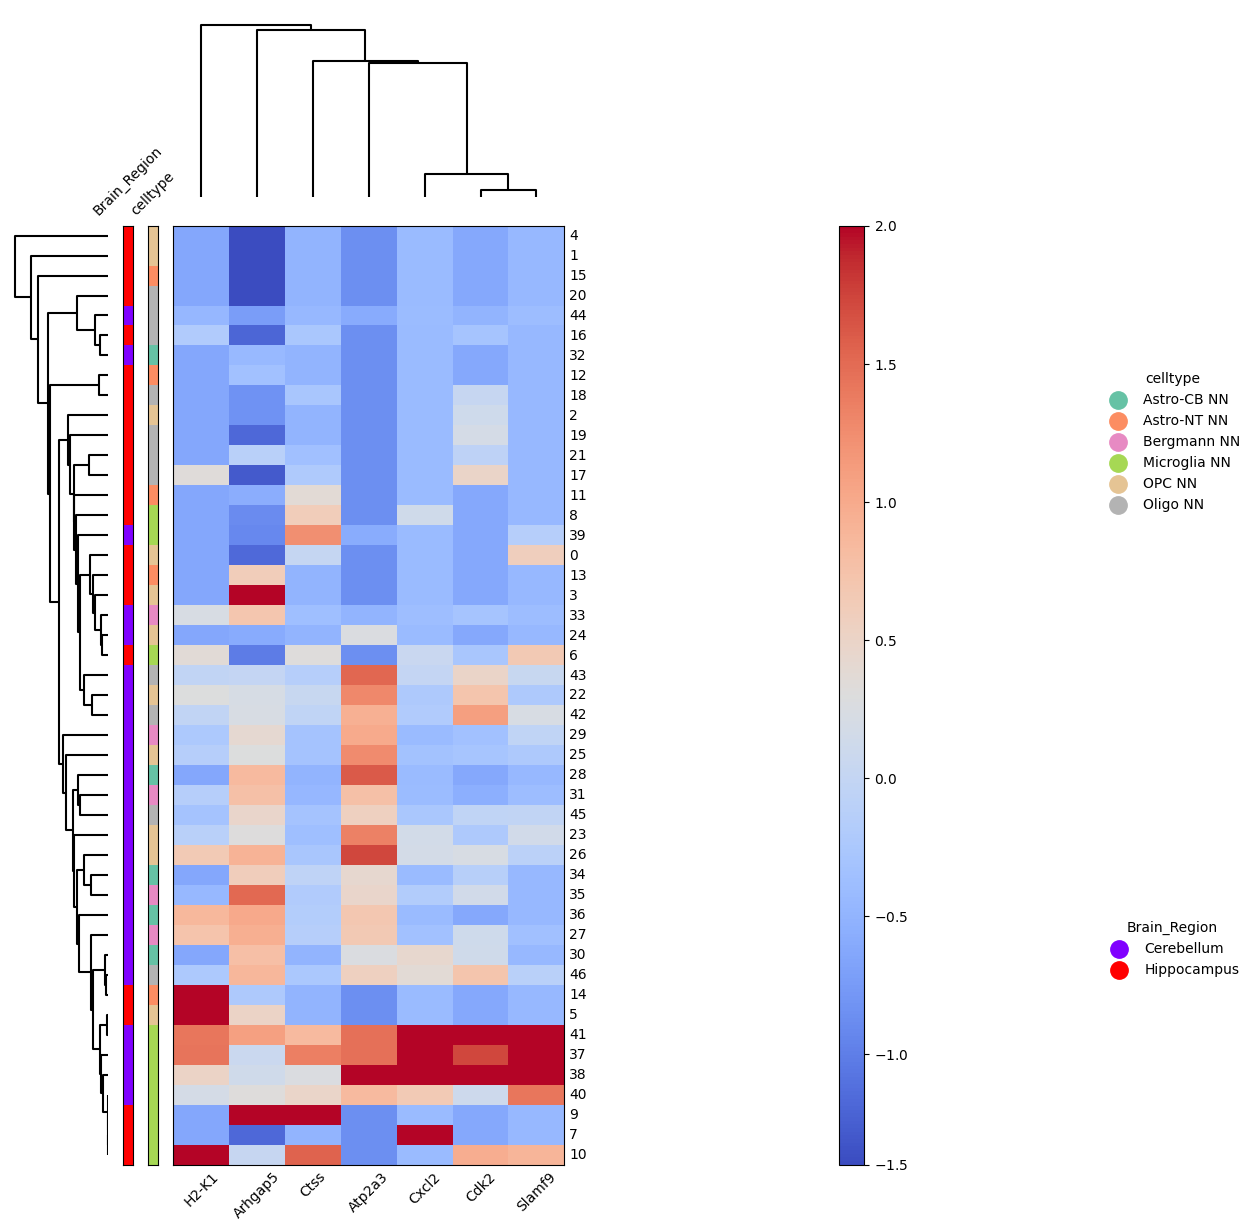

In [8]:
# want to show that the signal clusters microglia by the granules and not other glial cell types

pseudo = create_pseudobulk(adata_combined[(adata_combined.obs.Age == '24')])# & (adata_combined_peri.obs.Brain_Region == 'Cerebellum')])
pseudo_sub = pseudo[:,['Cdk2', 'Cxcl2', 'Slamf9', 'Arhgap5', 'Ctss', 'Atp2a3', 'H2-K1']]
counts_matrix = pseudo_sub.X
gene_names = pseudo_sub.var_names
cell_names = pseudo_sub.obs_names

# Create the DataFrame with obs_names as rows and var_names as columns
counts_df = pd.DataFrame(data=counts_matrix, index=cell_names, columns=gene_names)
zscored_df = counts_df.apply(zscore, axis=0)

subset_df = zscored_df

dfc = pseudo.obs.loc[:,['celltype','Brain_Region']]#,'peri']]
dfr = pseudo.obs.loc[:,['celltype','Brain_Region']]#,'peri']]

#dfr_sorted = dfr.sort_values(by='Brain_Region')

# Reorder `subset_df` to match the order of `dfr_sorted`
#subset_df_reordered = subset_df.loc[dfr_sorted.index]

cmaps={ 'peri':'RdYlGn', 'celltype':'Set2',
        'PC score':'gist_heat', 'Brain_Region':'rainbow'}

clipped_data = subset_df.clip(upper=2,lower= -2)
g = nhm(data=clipped_data,dfr=dfr, figsize=(15, 15), linewidths=0, cmaps=cmaps, showxticks=True,cmapCenter='coolwarm')
g.hcluster(method='single', metric='cosine', optimal_ordering=False)
fig, plots = g.run()
fig.savefig('figures/old_microglia_hp_y_cb_no_endo.pdf', bbox_inches='tight')

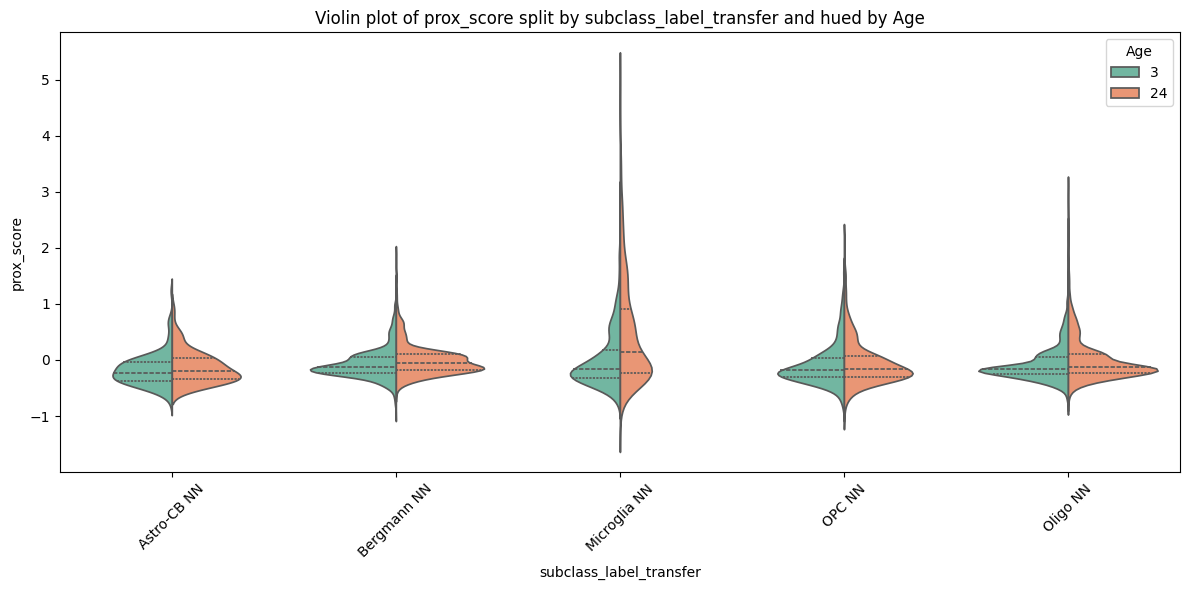

/tmp/ipykernel_828857/1787534816.py:330: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_categories = adata.obs.groupby([split_by, hue_by]).groups.keys()


In [9]:
# want to show how the score changes with age amongst the cerebellar cell types
sc.pp.scale(adata_subset_cb)
sc.tl.score_genes(adata_subset_cb,gene_list=['Cdk2', 'Cxcl2', 'Slamf9', 'Arhgap5', 'Ctss', 'Atp2a3', 'H2-K1'],score_name='prox_score')
results_df = plot_violin_with_stats(adata_subset_cb, 'prox_score', 'subclass_label_transfer',hue_by='Age',save_path='figures/cb_prox_score_by_ct_age.pdf')